<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/tabular_playground_series_jul_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

In [51]:
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/tabular-playground-series-jul-2021_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/tabular-playground-series-jul-2021_test.csv')
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/tabular-playground-series-jul-2021_sample_submission.csv')
train.shape, test.shape

((7111, 12), (2247, 9))

In [ ]:
base_train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/tabular-playground-series-jul-2021_train.csv', 
                         index_col = 0)
base_train.index = base_train.index.astype('datetime64[ns]')
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/tabular-playground-series-jul-2021_train.csv', 
                    index_col = 0)
train.index = train.index.astype('datetime64[ns]')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/tabular-playground-series-jul-2021_test.csv', 
                   index_col = 0)
test.index = test.index.astype('datetime64[ns]')

In [ ]:
train

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8
...,...,...,...,...,...,...,...,...,...,...,...,...
7106,2010-12-31 20:00:00,9.2,32.0,0.3871,1000.5,811.2,873.0,909.0,910.5,1.3,5.1,191.1
7107,2010-12-31 21:00:00,9.1,33.2,0.3766,1022.7,790.0,951.6,912.9,903.4,1.4,5.8,221.3
7108,2010-12-31 22:00:00,9.6,34.6,0.4310,1044.4,767.3,861.9,889.2,1159.1,1.6,5.2,227.4
7109,2010-12-31 23:00:00,8.0,40.7,0.4085,952.8,691.9,908.5,917.0,1206.3,1.5,4.6,199.8


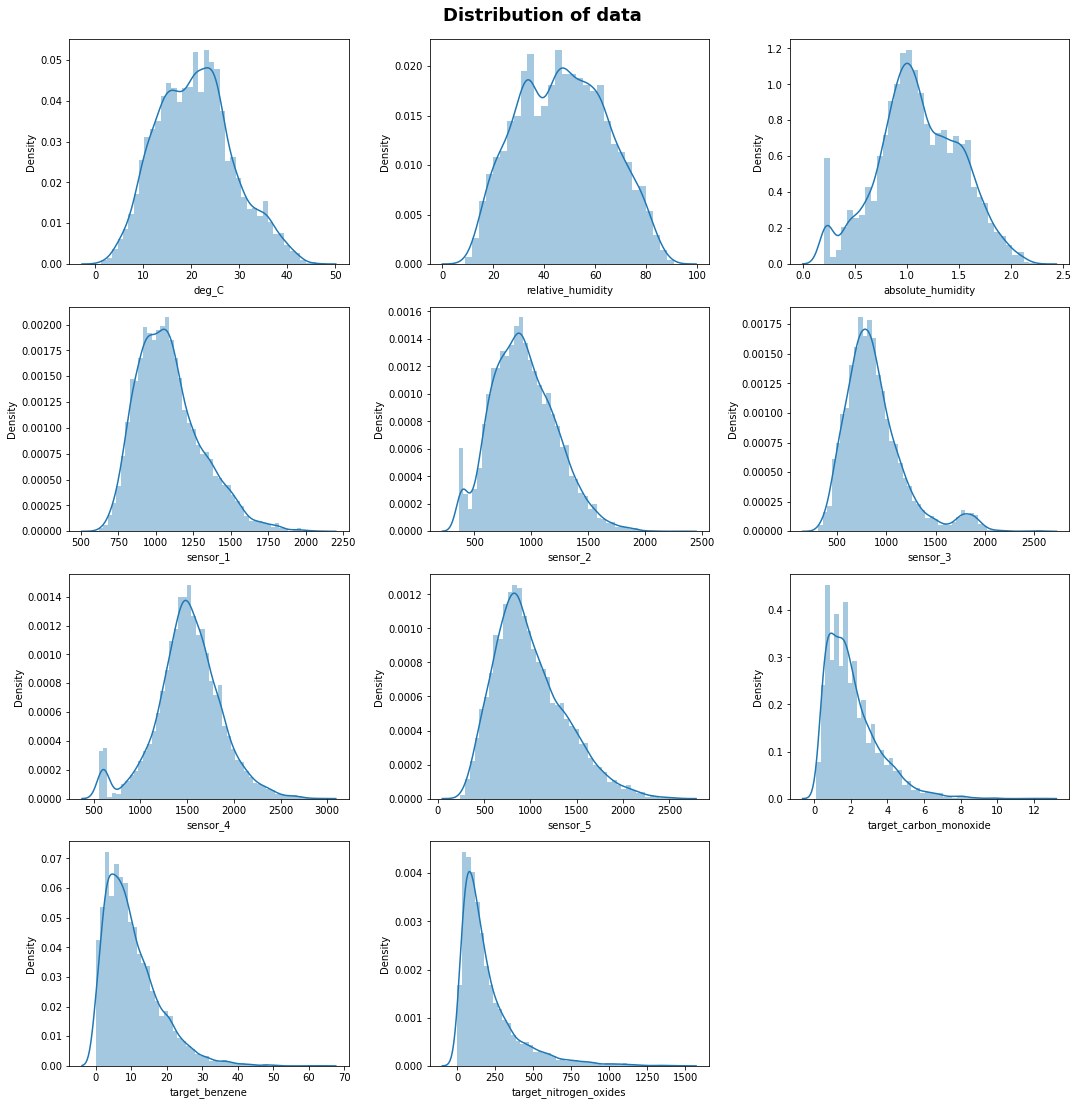

In [ ]:
plt.figure(figsize=(15,15))
for i,j in enumerate(train.select_dtypes('float').columns):
  plt.subplot(4,3, i+1)
  sns.distplot(train[j])
plt.suptitle('Distribution of data', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()


# target label이 3개 있는 시계열 데이터


date_time == 센서가 측정값을 내린 시간

deg_C == 온도

relative_humidity == 상대 습도 > 온도에 따라 달라짐

absolute_humidity == 절대 습도 > 온도가 증감 되더라도 가습 되지 않는 이상 절대 습도는 일정함

sensor_x == 센서 이름



In [52]:
train['date_time'] = pd.to_datetime(train['date_time'], format='%Y-%m-%d %H:%M:%S')
test['date_time'] = pd.to_datetime(test['date_time'], format='%Y-%m-%d %H:%M:%S')

In [53]:
# train['date'] = train['date_time'].dt.date
# test['date'] = test['date_time'].dt.date

# train['month'] = train['date_time'].dt.month  # month넣으면 overfitting
# test['month'] = test['date_time'].dt.month

train['day'] = train['date_time'].dt.day
test['day'] = test['date_time'].dt.day

train['hour'] = train['date_time'].dt.hour
test['hour'] = test['date_time'].dt.hour

train['weekday'] = train['date_time'].dt.weekday  # weekday를 카테고리로 해볼까
test['weekday'] = test['date_time'].dt.weekday

train['weekend'] = train['weekday'].apply(lambda x:1 if x in [5,6] else 0)
test['weekend'] = test['weekday'].apply(lambda x:1 if x in [5,6] else 0)

train['is_workingtime'] = train['hour'].apply(lambda x:1 if x in range(8, 21, 1) else 0)
test['is_workingtime'] = test['hour'].apply(lambda x:1 if x in range(8, 21, 1) else 0)

In [54]:
# object화
train['weekday'] = train['weekday'].astype('object')
test['weekday'] = test['weekday'].astype('object')

train['weekend'] = train['weekend'].astype('object')
test['weekend'] = test['weekend'].astype('object')

train['is_workingtime'] = train['is_workingtime'].astype('object')
test['is_workingtime'] = test['is_workingtime'].astype('object')

In [55]:
# dew point(이슬점)
def dew_point(df):

  b = 17.62
  c = 243.12

  gamma = (b * df['deg_C'] /(c + df['deg_C'])) + np.log(df['relative_humidity'] / 100.0)
  dewpoint = (c * gamma) / (b - gamma)

  return dewpoint

train['dewpoint'] = dew_point(train)
test['dewpoint'] = dew_point(test)

In [56]:
train

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides,day,hour,weekday,weekend,is_workingtime,dewpoint
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7,10,18,2,0,1,1.727907
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9,10,19,2,0,1,1.604653
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1,10,20,2,0,1,4.095906
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2,10,21,2,0,0,4.084138
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8,10,22,2,0,0,4.133561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7106,2010-12-31 20:00:00,9.2,32.0,0.3871,1000.5,811.2,873.0,909.0,910.5,1.3,5.1,191.1,31,20,4,0,1,-6.669204
7107,2010-12-31 21:00:00,9.1,33.2,0.3766,1022.7,790.0,951.6,912.9,903.4,1.4,5.8,221.3,31,21,4,0,0,-6.275931
7108,2010-12-31 22:00:00,9.6,34.6,0.4310,1044.4,767.3,861.9,889.2,1159.1,1.6,5.2,227.4,31,22,4,0,0,-5.290964
7109,2010-12-31 23:00:00,8.0,40.7,0.4085,952.8,691.9,908.5,917.0,1206.3,1.5,4.6,199.8,31,23,4,0,0,-4.570841


Text(0.5, 1.0, 'date vs target')

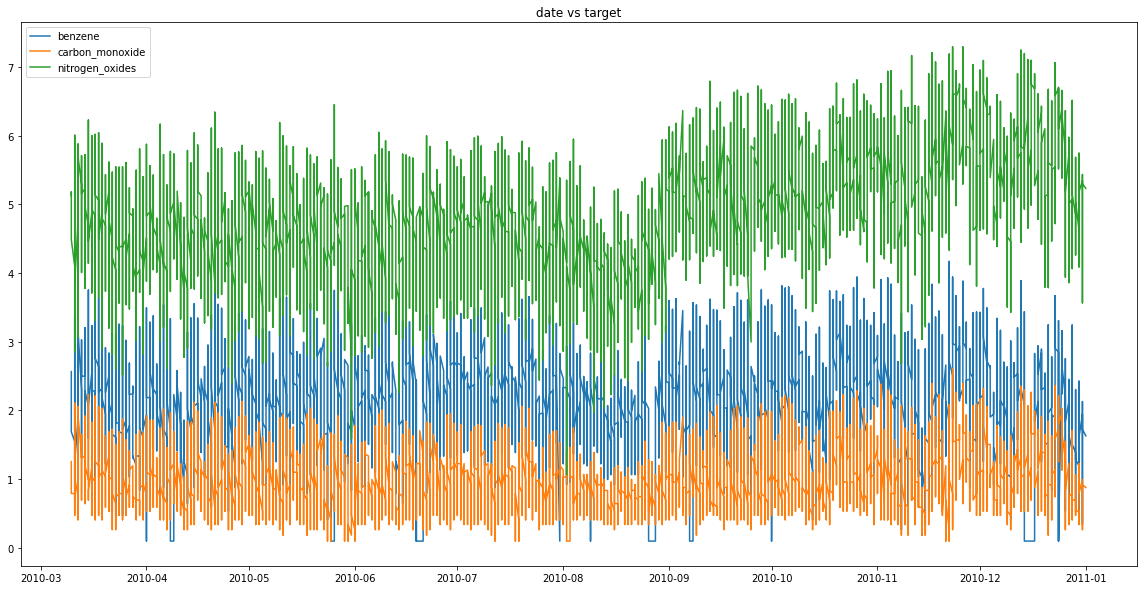

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(train['date'], np.log1p(train['target_benzene']), label='benzene')
plt.plot(train['date'], np.log1p(train['target_carbon_monoxide']), label='carbon_monoxide')
plt.plot(train['date'], np.log1p(train['target_nitrogen_oxides']), label='nitrogen_oxides')
plt.legend()
plt.title('date vs target')

Text(0.5, 1.0, 'deg_C vs target')

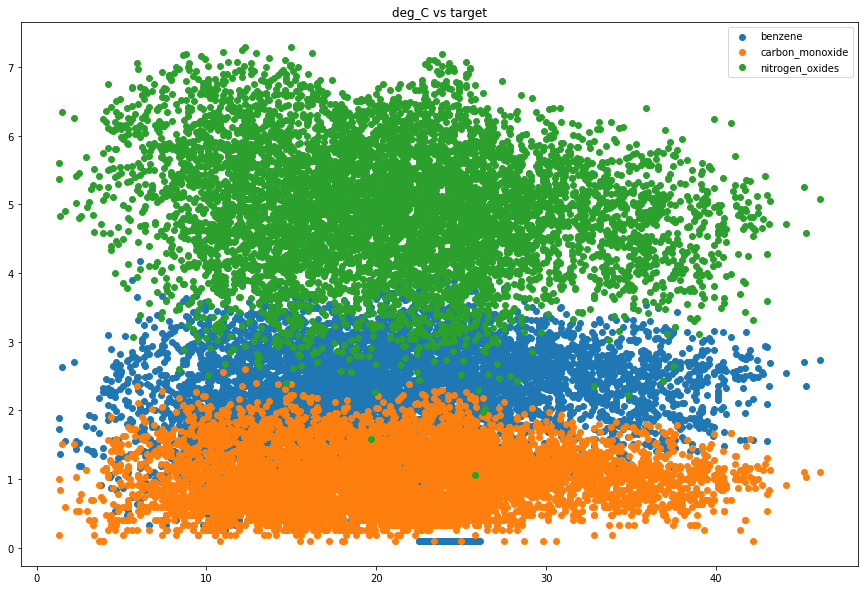

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(train['deg_C'], np.log1p(train['target_benzene']), label='benzene', )
plt.scatter(train['deg_C'], np.log1p(train['target_carbon_monoxide']), label='carbon_monoxide')
plt.scatter(train['deg_C'], np.log1p(train['target_nitrogen_oxides']), label='nitrogen_oxides')
plt.legend()
plt.title('deg_C vs target')

Text(0.5, 1.0, 'relative_humidity vs target')

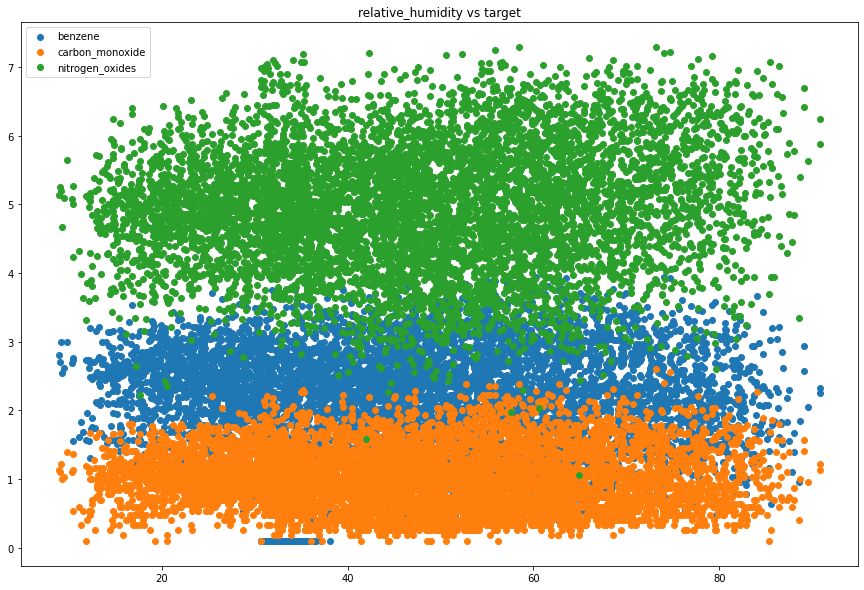

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(train['relative_humidity'], np.log1p(train['target_benzene']), label='benzene', )
plt.scatter(train['relative_humidity'], np.log1p(train['target_carbon_monoxide']), label='carbon_monoxide')
plt.scatter(train['relative_humidity'], np.log1p(train['target_nitrogen_oxides']), label='nitrogen_oxides')
plt.legend()
plt.title('relative_humidity vs target')

Text(0.5, 1.0, 'absolute_humidity vs target')

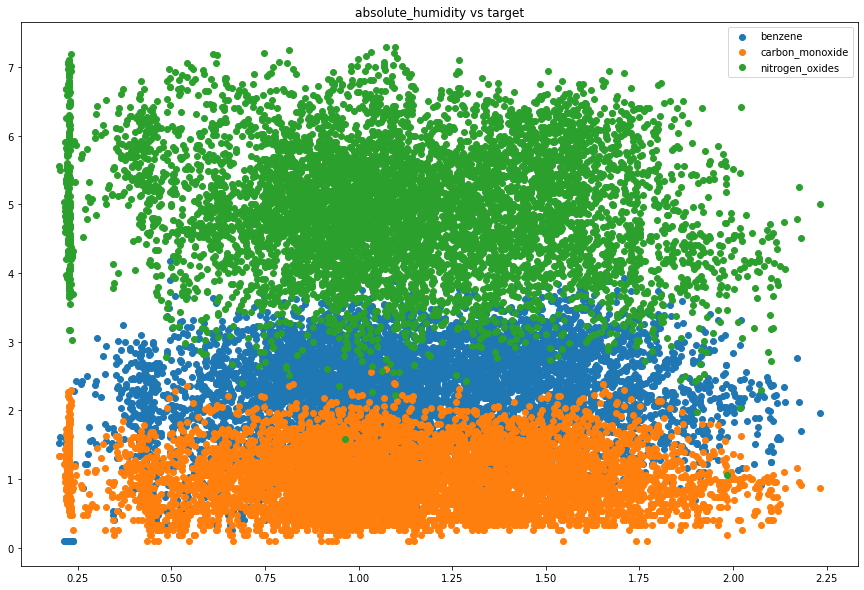

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(train['absolute_humidity'], np.log1p(train['target_benzene']), label='benzene', )
plt.scatter(train['absolute_humidity'], np.log1p(train['target_carbon_monoxide']), label='carbon_monoxide')
plt.scatter(train['absolute_humidity'], np.log1p(train['target_nitrogen_oxides']), label='nitrogen_oxides')
plt.legend()
plt.title('absolute_humidity vs target')

# 시각화를 통해
nitrigen_oxides는 날짜의 영향을 받는다(== 날씨의 영향을 받는다)

bengene, carbon은 날짜의 영향을 받지 않는듯하다(== 날씨의 영향을 덜 받는다)



---

# 시계열별 EDA



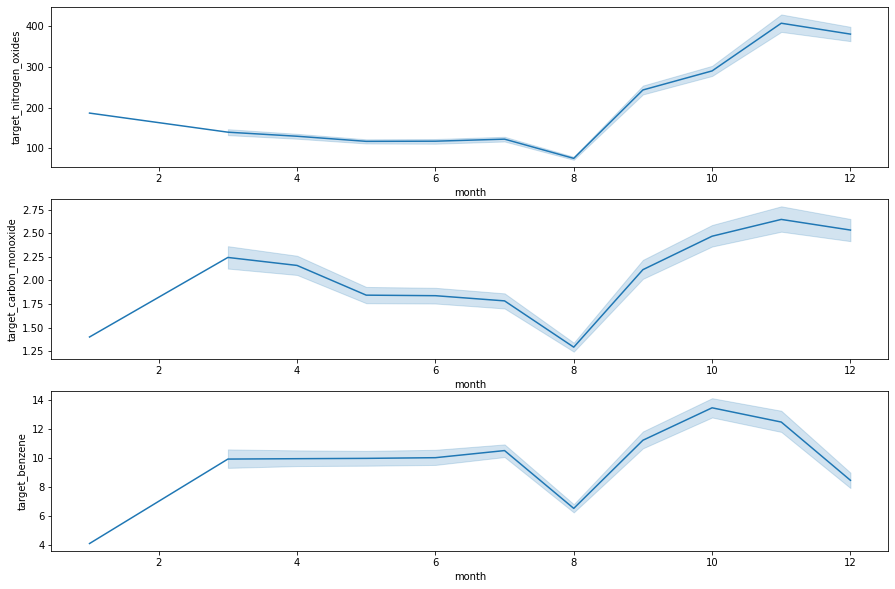

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(15,10))
sns.lineplot(train['month'], train['target_nitrogen_oxides'], ax=ax[0])
sns.lineplot(train['month'], train['target_carbon_monoxide'], ax=ax[1])
sns.lineplot(train['month'], train['target_benzene'], ax=ax[2])

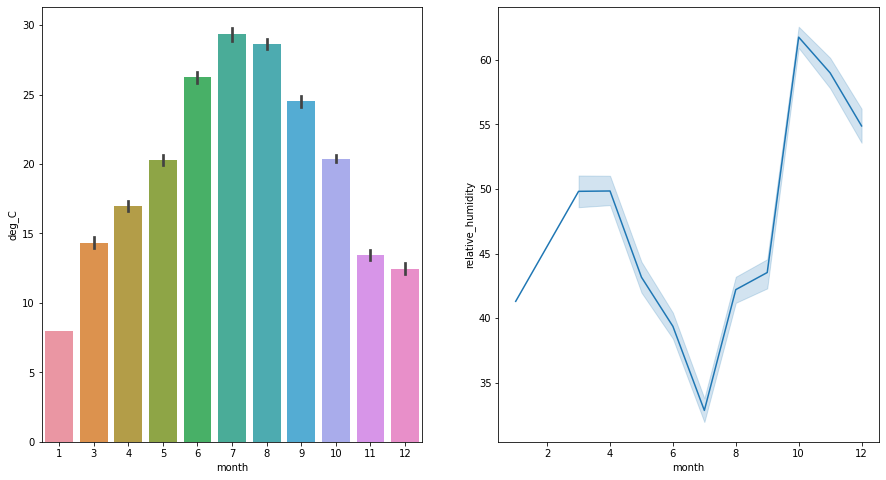

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,8))
sns.barplot(train['month'], train['deg_C'], ax=ax[0])
sns.lineplot(train['month'], train['relative_humidity'], ax=ax[1])

여름에는 덥고 건조하고 겨울에는 춥고 습윤하다 ==> 지중해 날씨??

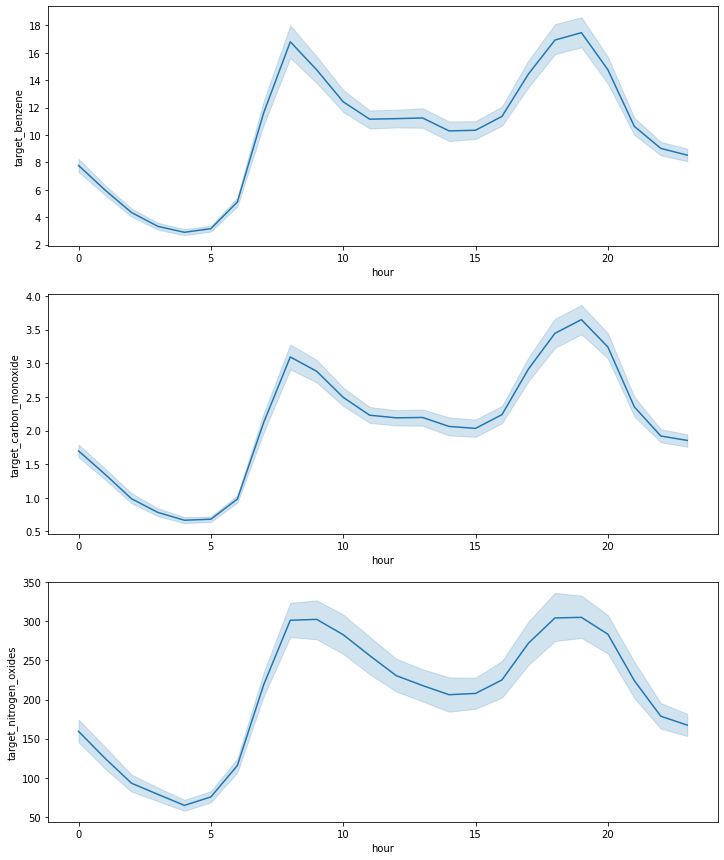

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(12,15))
sns.lineplot(train['hour'], train['target_benzene'], ax=ax[0])
sns.lineplot(train['hour'], train['target_carbon_monoxide'], ax=ax[1])
sns.lineplot(train['hour'], train['target_nitrogen_oxides'], ax=ax[2])

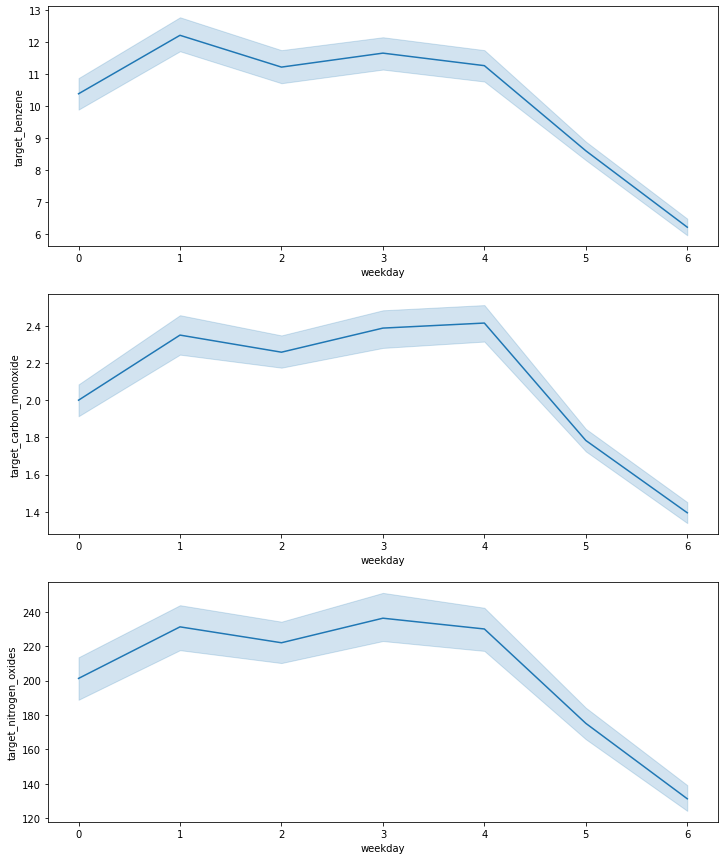

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(12,15))
sns.lineplot(train['weekday'], train['target_benzene'], ax=ax[0])
sns.lineplot(train['weekday'], train['target_carbon_monoxide'], ax=ax[1])
sns.lineplot(train['weekday'], train['target_nitrogen_oxides'], ax=ax[2])

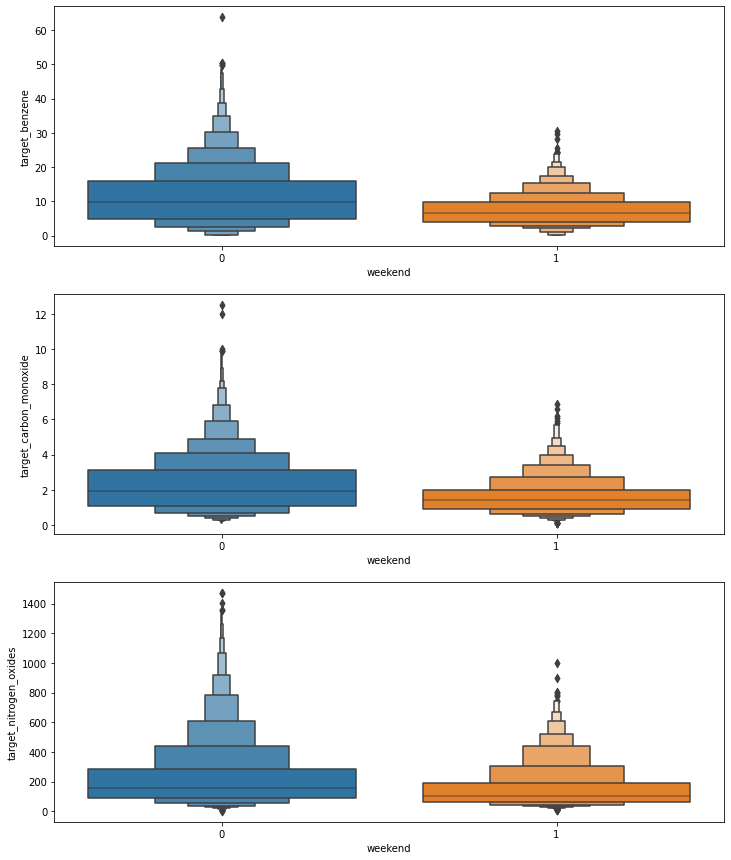

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(12,15))
sns.boxenplot(train['weekend'], train['target_benzene'], ax=ax[0])
sns.boxenplot(train['weekend'], train['target_carbon_monoxide'], ax=ax[1])
sns.boxenplot(train['weekend'], train['target_nitrogen_oxides'], ax=ax[2])

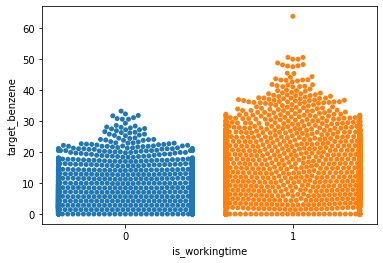

In [73]:
sns.swarmplot(train['is_workingtime'], train['target_benzene'])

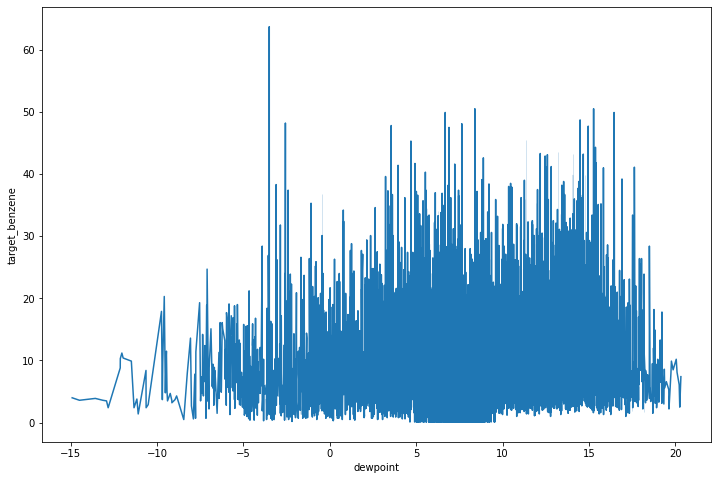

In [78]:
plt.figure(figsize=(12,8))
sns.lineplot(train['dewpoint'], train['target_benzene'])

hour 변수로 시각화해서 알 수 있는 것 ==> 시간 별로 target값이 불규칙하다 ==> 유의미한 column이다.

weekday 변수로 시각화해서 알 수 있는 것 ==> 유의미한 차이가 관찰됨 ==> 유의미한 column

weekend 변수로 시각화해서 알 수 있는 것 ==> 차이가 있다. ==> 유의미한 column

* 시계열 변수는 hour, weekday, weekend 변수만 챙겨간다.

In [6]:
pip install catboost

     |████████████████████████████████| 69.2MB 43kB/s 


In [7]:
pip install optuna

     |████████████████████████████████| 307kB 31.4MB/s 
     |████████████████████████████████| 81kB 10.6MB/s 
     |████████████████████████████████| 174kB 47.1MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 112kB 49.0MB/s 
     |████████████████████████████████| 143kB 48.1MB/s 
     |████████████████████████████████| 81kB 11.3MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11136 sha256=8d13affb175b05e1a9a16350b63fcd2957570361ecc9e17092d0597688154e38
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [57]:
import catboost
import xgboost
import lightgbm as lgbm
import optuna
from sklearn.model_selection import StratifiedKFold, KFold, cross_validate, train_test_split
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.preprocessing import robust_scale, StandardScaler, MinMaxScaler
rmsle = make_scorer(mean_squared_log_error, greater_is_better=False)

In [58]:
x_train = train.drop(columns=['date_time', 'target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides'])
y1_train = np.log1p(train['target_carbon_monoxide'])
y2_train = np.log1p(train['target_benzene'])
y3_train = np.log1p(train['target_nitrogen_oxides'])
x_test = test.drop(columns=['date_time'])

train_col = x_train.columns
test_col = x_train.columns

In [ ]:
x_train = train.drop(columns=['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides'])
y1_train = train['target_carbon_monoxide']
y2_train = train['target_benzene']
y3_train = train['target_nitrogen_oxides']
x_test = test.copy()

train_col = x_train.columns
test_col = x_train.columns

In [ ]:
for i in x_train.columns:
  if x_train[i].skew() > 0.5:
    x_train[i] = boxcox1p(x_train[i], boxcox_normmax(x_train[i]+1))
    x_test[i] = boxcox1p(x_test[i], boxcox_normmax(x_test[i]+1))

In [ ]:
# StandardScaler
sc = StandardScaler().fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

In [59]:
# MinMaxScaler
for i in x_train.select_dtypes(exclude='object').columns:
  sc = MinMaxScaler().fit(x_train[[i]])
  x_train[i] = sc.transform(x_train[[i]])
  x_test[i] = sc.transform(x_test[[i]])

In [60]:
x_train = pd.DataFrame(x_train, columns=train_col)
x_test = pd.DataFrame(x_test, columns=test_col)

In [ ]:
# 성능 안좋음
# x_train = pd.DataFrame(robust_scale(x_train), columns=train_col)
# x_test = pd.DataFrame(robust_scale(x_test), columns=test_col)

# target : carbon_monoxide 모델링

In [61]:
cat_features = x_train.select_dtypes('object').columns

def objective(trial,data=x_train,target=y1_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 25000),
             'loss_function':'RMSE',
              'task_type':"GPU",
              'eval_metric':'RMSE',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,10),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Lossguide',
              'cat_features' : cat_features
               }
    model = catboost.CatBoostRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_preds))
    
    return RMSLE

In [62]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-07-08 07:41:09,813] A new study created in memory with name: no-name-11cd22d8-0e09-4cd0-a984-f148ae254e1b
[I 2021-07-08 07:41:19,433] Trial 0 finished with value: 0.05151793058234539 and parameters: {'iterations': 21409, 'learning_rate': 0.3843867847824982, 'reg_lambda': 95.34719309604881, 'subsample': 0.5671811708535706, 'random_strength': 24.861385017490907, 'depth': 3, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 1}. Best is trial 0 with value: 0.05151793058234539.
[I 2021-07-08 07:42:33,789] Trial 1 finished with value: 0.05121648906994949 and parameters: {'iterations': 17327, 'learning_rate': 0.13825343574722168, 'reg_lambda': 63.841457412149765, 'subsample': 0.025281614279005327, 'random_strength': 43.42465663890603, 'depth': 9, 'min_data_in_leaf': 7, 'leaf_estimation_iterations': 10}. Best is trial 1 with value: 0.05121648906994949.
[I 2021-07-08 07:43:06,877] Trial 2 finished with value: 0.05409749334447617 and parameters: {'iterations': 23859, 'learning_rate':

Number of finished trials: 50
Best trial: score 0.0475081375727828, params {'iterations': 17712, 'learning_rate': 0.06382446530308791, 'reg_lambda': 73.47024367397653, 'subsample': 0.398866589883332, 'random_strength': 28.817018014011158, 'depth': 7, 'min_data_in_leaf': 37, 'leaf_estimation_iterations': 10}


In [63]:
skf = StratifiedKFold(n_splits=5, shuffle=False, random_state=42)
kf = KFold(n_splits=7, shuffle=False, random_state=42)
preds_cat_1 = np.zeros((x_test.shape[0],))
param_y1 = {'iterations':study.best_params['iterations'],
             'loss_function':'RMSE',
             'task_type':"GPU",
             'eval_metric':'RMSE',
             'leaf_estimation_method':'Newton',
             'bootstrap_type': 'Bernoulli',
             'learning_rate' : study.best_params['learning_rate'],
             'reg_lambda': study.best_params['reg_lambda'],
             'subsample': study.best_params['subsample'],
             'random_strength': study.best_params['random_strength'],
             'depth': study.best_params['depth'],
             'min_data_in_leaf': study.best_params['min_data_in_leaf'],
             'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
             'grow_policy' : 'Lossguide',
             'cat_features' : cat_features
    
}

for i,(train_index, valid_index) in enumerate(kf.split(x_train, y1_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y1_train.iloc[train_index], y1_train.iloc[valid_index]

  model_cat = catboost.CatBoostRegressor(**param_y1)
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), early_stopping_rounds=70, verbose=100)

  preds_cat_1 += model_cat.predict(x_test)/kf.n_splits
  preds_cat_val = model_cat.predict(X_valid)
  RMSLE = mean_squared_log_error(Y_valid, preds_cat_val)
  print(f'{i+1}번째 RMSLE:{np.sqrt(RMSLE)}')

0:	learn: 0.4118919	test: 0.3820901	best: 0.3820901 (0)	total: 32.1ms	remaining: 9m 28s
100:	learn: 0.1000574	test: 0.1054641	best: 0.1042533 (58)	total: 3.17s	remaining: 9m 13s
bestTest = 0.1042532759
bestIteration = 58
Shrink model to first 59 iterations.
1번째 RMSLE:0.052234540909319935
0:	learn: 0.4067564	test: 0.4105761	best: 0.4105761 (0)	total: 31.6ms	remaining: 9m 19s
100:	learn: 0.0967662	test: 0.1275145	best: 0.1274034 (97)	total: 3.1s	remaining: 9m
bestTest = 0.1270060382
bestIteration = 106
Shrink model to first 107 iterations.
2번째 RMSLE:0.07256539860209882
0:	learn: 0.4122089	test: 0.3766456	best: 0.3766456 (0)	total: 29.7ms	remaining: 8m 45s
100:	learn: 0.0980645	test: 0.1192916	best: 0.1187999 (85)	total: 3.01s	remaining: 8m 44s
200:	learn: 0.0856618	test: 0.1177038	best: 0.1171553 (188)	total: 6.3s	remaining: 9m 9s
bestTest = 0.1171552959
bestIteration = 188
Shrink model to first 189 iterations.
3번째 RMSLE:0.061307800390858064
0:	learn: 0.4147542	test: 0.3647231	best: 0.36

# target_benzene 모델링

In [64]:
def objective(trial,data=x_train,target=y2_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 25000),
             'loss_function':'RMSE',
              'task_type':"GPU",
              'eval_metric':'RMSE',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,10),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Lossguide',
              'cat_features' : cat_features
               }
    model = catboost.CatBoostRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_preds))
    
    return RMSLE

In [65]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-07-08 08:36:15,816] A new study created in memory with name: no-name-689c3e32-7c60-4306-8a2f-3c5eea0899f8
[I 2021-07-08 08:36:50,779] Trial 0 finished with value: 0.03169263576658146 and parameters: {'iterations': 10354, 'learning_rate': 0.278753019160389, 'reg_lambda': 81.96073382005059, 'subsample': 0.1362991797883143, 'random_strength': 44.98158968492189, 'depth': 6, 'min_data_in_leaf': 20, 'leaf_estimation_iterations': 14}. Best is trial 0 with value: 0.03169263576658146.
[I 2021-07-08 08:37:05,142] Trial 1 finished with value: 0.031994335065835065 and parameters: {'iterations': 15296, 'learning_rate': 0.33674772900687316, 'reg_lambda': 85.66983384042771, 'subsample': 0.2603355032303819, 'random_strength': 49.10230166099837, 'depth': 9, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 14}. Best is trial 0 with value: 0.03169263576658146.
[I 2021-07-08 08:37:32,317] Trial 2 finished with value: 0.029840090822868166 and parameters: {'iterations': 4607, 'learning_rate': 0.

KeyboardInterrupt: ignored

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=False, random_state=42)
kf = KFold(n_splits=7, shuffle=False, random_state=42)
preds_cat_2 = np.zeros((x_test.shape[0],))
param_y2 = {'iterations':study.best_params['iterations'],
             'loss_function':'RMSE',
             'task_type':"GPU",
             'eval_metric':'RMSE',
             'leaf_estimation_method':'Newton',
             'bootstrap_type': 'Bernoulli',
             'learning_rate' : study.best_params['learning_rate'],
             'reg_lambda': study.best_params['reg_lambda'],
             'subsample': study.best_params['subsample'],
             'random_strength': study.best_params['random_strength'],
             'depth': study.best_params['depth'],
             'min_data_in_leaf': study.best_params['min_data_in_leaf'],
             'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
             'grow_policy' : 'Lossguide',
             'cat_features' : cat_features
    
}

for i,(train_index, valid_index) in enumerate(kf.split(x_train, y2_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y2_train.iloc[train_index], y2_train.iloc[valid_index]

  model_cat2 = catboost.CatBoostRegressor(**param_y2, use_best_model=True)
  model_cat2.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), early_stopping_rounds=70, verbose=100)

  preds_cat_2 += model_cat2.predict(x_test) / kf.n_splits
  preds_cat_val = model_cat2.predict(X_valid)
  RMSLE = mean_squared_log_error(np.exp(Y_valid), np.exp(preds_cat_val))
  print(f'RMSLE:{np.sqrt(RMSLE)}')

In [ ]:
pd.Series(np.expm1(preds_cat_2)).value_counts().sort_index()

0.072400     1
0.075145     1
0.076354     1
0.077407     1
0.077945     1
            ..
36.072376    1
38.862937    1
39.355093    1
40.072970    1
43.938583    1
Length: 2247, dtype: int64

# target_nitrogen_oxides 모델링

In [ ]:
def objective(trial,data=x_train,target=y3_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 25000),
             'loss_function':'RMSE',
              'task_type':"GPU",
              'eval_metric':'RMSE',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,10),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Lossguide',
              'cat_features' : cat_features
               }
    model = catboost.CatBoostRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_preds))
    
    return RMSLE

In [ ]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=False, random_state=42)
kf = KFold(n_splits=7, shuffle=False, random_state=42)
preds_cat_3 = np.zeros((x_test.shape[0]))
param_y3 = {'iterations':study.best_params['iterations'],
             'loss_function':'RMSE',
             'task_type':"GPU",
             'eval_metric':'RMSE',
             'leaf_estimation_method':'Newton',
             'bootstrap_type': 'Bernoulli',
             'learning_rate' : study.best_params['learning_rate'],
             'reg_lambda': study.best_params['reg_lambda'],
             'subsample': study.best_params['subsample'],
             'random_strength': study.best_params['random_strength'],
             'depth': study.best_params['depth'],
             'min_data_in_leaf': study.best_params['min_data_in_leaf'],
             'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
             'grow_policy' : 'Lossguide',
             'cat_features' : cat_features
    
}

for i,(train_index, valid_index) in enumerate(kf.split(x_train, y3_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y3_train.iloc[train_index], y3_train.iloc[valid_index]

  model_cat3 = catboost.CatBoostRegressor(**param_y3)
  model_cat3.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), early_stopping_rounds=70, verbose=100)

  preds_cat_3 += model_cat3.predict(x_test)/kf.n_splits
  preds_cat_val = model_cat3.predict(X_valid)
RMSLE = mean_squared_log_error(Y_valid, preds_cat_val)
print(f'{i+1}번째 RMSLE:{np.sqrt(RMSLE)}')

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/tabular-playground-series-jul-2021_sample_submission.csv')
submit = submit.set_index('date_time')

submit['target_carbon_monoxide'] = np.expm1(preds_cat_1)
submit['target_benzene'] = np.expm1(preds_cat_2)
submit['target_nitrogen_oxides'] = np.expm1(preds_cat_3)

submit

In [22]:
submit.to_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/submit16.csv')

# conclusion

* 시계열 feature 들은 day, hour, weekday, weekend로 만족
* month는 overfitting
* shuffle = False로 하니까 점수 상승(?)

# To_do
 * 시계열 데이터 이니까 shuffle=False로 하고 해보자
 
 * weekday를 object화 하기

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/tabular-playground-series-jul-2021_sample_submission.csv')
submit = submit.set_index('date_time')

submit['target_carbon_monoxide'] = preds_cat_1
submit['target_benzene'] = preds_cat_2
submit['target_nitrogen_oxides'] = preds_cat_3

submit.to_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/submit9.csv')